# PREDICTING THE STOCK MARKET


In this project, we'll be working with data from the S&P500 Index. The S&P500 is a stock market index.

We'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in sphist.csv.

The columns of the dataset are:

    Date -- The date of the record.

    Open -- The opening price of the day (when trading starts).

    High -- The highest trade price during the day.

    Low -- The lowest trade price during the day.

    Close -- The closing price for the day (when trading is finished).

    Volume -- The number of shares traded.

    Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions.

We'll be using this dataset to develop a predictive model. You'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.



# 1. Data introduction

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

In [2]:

df = pd.read_csv('sphist.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date']).reset_index(drop=True)
df.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


# 2. Generate indicators

Here are some indicators that are interesting to generate for each row:

- The average price from the past 5 days.
- The average price for the past 30 days.
- The average price for the past 365 days.
- The ratio between the average price for the past 5 days, and the average price for the past 365 days.
- The standard deviation of the price over the past 5 days.
- The standard deviation of the price over the past 365 days.
- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.


In [4]:
df['avg_5'] = df['Close'].rolling(5).mean().shift()
#df.head(20)
df['avg_30'] = df['Close'].rolling(30).mean().shift()
df['avg_365'] = df['Close'].rolling(365).mean().shift()

In [5]:
df['std_5'] = df['Close'].rolling(5).std().shift()
df['std_30'] = df['Close'].rolling(30).std().shift()
df['std_365'] = df['Close'].rolling(365).std().shift()

In [6]:
df['rat_avg'] = df['avg_5'] / df['avg_365']

df['rat_std'] = df['std_5'] / df['std_365']

# 3. Remove Null values

- Remove all data occurs before 1950-01-30
- Remove any rows with NaN values
- Generate train and test dataframe

In [7]:
#df = df[df['Date'] > datetime.date(2020,1,2)]
df.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
Adj Close      0
avg_5          5
avg_30        30
avg_365      365
std_5          5
std_30        30
std_365      365
rat_avg      365
rat_std      365
dtype: int64

In [8]:
df = df[df['Date'] > np.datetime64('1950-01-02')]


In [9]:
df.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
Adj Close      0
avg_5          5
avg_30        30
avg_365      365
std_5          5
std_30        30
std_365      365
rat_avg      365
rat_std      365
dtype: int64

In [10]:
df = df.dropna(axis=0)
df.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_5,avg_30,avg_365,std_5,std_30,std_365,rat_avg,rat_std
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,0.256223,0.473595,1.790253,1.120954,0.143121
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,0.213659,0.444648,1.789307,1.125246,0.119409
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,0.092574,0.411452,1.788613,1.128142,0.051758
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,0.115108,0.368514,1.787659,1.126757,0.064390
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,0.204132,0.329130,1.786038,1.121008,0.114293


In [11]:
# split the dataframe into train and test set

train = df[df['Date'] < datetime(year=2013, month=1, day=1)]

test = df[df['Date'] >= datetime(year=2013, month=1, day=1)]


In [12]:
print('train: {} rows, {}% of total data'.format(len(train), round(len(train)/len(df) *100,2)))

print('test: {} rows, {}% of total data'.format(len(test), round(len(test)/len(df)*100, 2)))

train: 15486 rows, 95.45% of total data
test: 739 rows, 4.55% of total data


# 4. Feature selection


In [16]:
features = [col for col in df.columns if (col.startswith('avg') or col.startswith('std') or 
           col.startswith('rat'))]

features.append('Close')

ax = df[features].corr()
ax

,avg_5,avg_30,avg_365,std_5,std_30,std_365,rat_avg,rat_std,Close
avg_5,1.000000,0.999472,0.989235,0.723713,0.778835,0.816110,0.047077,0.088080,0.999793
avg_30,0.999472,1.000000,0.990682,0.734546,0.784461,0.816383,0.037703,0.096957,0.999189
avg_365,0.989235,0.990682,1.000000,0.765109,0.821646,0.842691,-0.057614,0.113230,0.988870
std_5,0.723713,0.734546,0.765109,1.000000,0.807449,0.721412,-0.174687,0.413709,0.722414
std_30,0.778835,0.784461,0.821646,0.807449,1.000000,0.787580,-0.182073,0.175819,0.778583
std_365,0.816110,0.816383,0.842691,0.721412,0.787580,1.000000,-0.105164,-0.035165,0.816103
rat_avg,0.047077,0.037703,-0.057614,-0.174687,-0.182073,-0.105164,1.000000,-0.265775,0.047782
rat_std,0.088080,0.096957,0.113230,0.413709,0.175819,-0.035165,-0.265775,1.000000,0.087018
Close,0.999793,0.999189,0.988870,0.722414,0.778583,0.816103,0.047782,0.087018,1.000000


<AxesSubplot:>

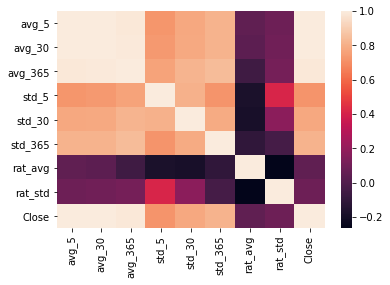

In [17]:
sns.heatmap(ax)

According to the correlation matrix, we can choose the features have high correlations with the 'Close' column. Therefore, the features **rat_avg** and **rat_std** will be removed

# 5. Train model

In [30]:
def train_and_test(df, cols, k):
    
    model = LinearRegression()
    
    if k==0:
        model.fit(df[cols], df['Close'])
        predictions = model.predict(df[cols])
        mse = mean_squared_error(df['Close'], predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(df['Close'], predictions)
        var_pred = np.var(predictions)
        
        return rmse, mae, var_pred
    
    if k==1:
        train = df[df['Date'] < datetime(year=2013, month=1, day=1)]
        test = df[df['Date'] >= datetime(year=2013, month=1, day=1)]
        model.fit(train[cols], train['Close'])
        predictions = model.predict(test[cols])
        mse = mean_squared_error(test['Close'], predictions)
        rmse=np.sqrt(mse)
        mae = mean_absolute_error(test['Close'], predictions)
        var_pred = np.var(predictions)
        
        return rmse, mae, var_pred
    
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        
        mses = cross_val_score(model, df[cols],df['Close'], scoring='neg_mean_squared_error', cv=kf)
        mse = np.mean([abs(n) for n in mses])
        rmse=np.sqrt(mse)
        
        maes = cross_val_score(model, df[cols],df['Close'], scoring='neg_mean_absolute_error', cv=kf)
        avg_mae = np.mean([abs(n) for n in maes])
        
        return rmse, avg_mae

    

In [32]:
cols = [col for col in df.columns if (col.startswith('avg') or col.startswith('std') )]
cols

['avg_5', 'avg_30', 'avg_365', 'std_5', 'std_30', 'std_365']

In [37]:
for k in range(0,11):
    results = train_and_test(df,cols, k)
    
    if k == 0:
        print('RMSE = {:.2f}, MAE = {:.2f}, VAR={:.2f}'.format(results[0], results[1], results[2]),' for {} fold cross validation'.format(k))
        
    if k == 1:
        print('RMSE = {:.2f}, MAE = {:.2f}, VAR={:.2f}'.format(results[0], results[1], results[2]),' for {} fold cross validation'.format(k))
     
    else:
        print('AVG_RMSE = {:.2f}, AVG_MAE = {:.2f}'.format(results[0], results[1]),' for {} fold cross validation'.format(k))
        

RMSE = 11.22, MAE = 5.48, VAR=309882.23  for 0 fold cross validation
AVG_RMSE = 11.22, AVG_MAE = 5.48  for 0 fold cross validation
RMSE = 22.20, MAE = 16.21, VAR=37277.94  for 1 fold cross validation
AVG_RMSE = 11.27, AVG_MAE = 5.50  for 2 fold cross validation
AVG_RMSE = 11.25, AVG_MAE = 5.49  for 3 fold cross validation
AVG_RMSE = 11.25, AVG_MAE = 5.49  for 4 fold cross validation
AVG_RMSE = 11.24, AVG_MAE = 5.49  for 5 fold cross validation
AVG_RMSE = 11.24, AVG_MAE = 5.49  for 6 fold cross validation
AVG_RMSE = 11.24, AVG_MAE = 5.49  for 7 fold cross validation
AVG_RMSE = 11.23, AVG_MAE = 5.49  for 8 fold cross validation
AVG_RMSE = 11.24, AVG_MAE = 5.49  for 9 fold cross validation
AVG_RMSE = 11.24, AVG_MAE = 5.49  for 10 fold cross validation


According to the model, we find that for each cross validation, the MAE or MSE are similar among different k values, which is a little strange.

This results might be caused because the dependence between observations, and the use of observation indicators based really in previous observations.



# 6. Predict future price

we can define a function to predict the future price based on its previous data.

In [63]:
def one_day_before(date, df, cols):
    
    try: 
        index = df[df['Date'] == date].index[0]
    
    except:
        
        print("This date doesn't exist in the dataset")
        
        return
    
    X = df.loc[:index]
    Y = df.loc[index]
    
    model = LinearRegression()
    model.fit(X[cols], X['Close'])
    prediction = model.predict([Y[cols]]) 
    
    return prediction[0]
    

### Generate the new column of predicted price

In [66]:
df_test = df[df['Date'] >= datetime(year = 2013, month = 1, day = 1)].copy()

df_test['pred_price'] = df_test.apply(lambda row: one_day_before(row.loc['Date'],df, cols), axis=1)

In [67]:
df_test.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_5,avg_30,avg_365,std_5,std_30,std_365,rat_avg,rat_std,pred_price
15851,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055,9.820801,17.834740,90.463948,1.068629,0.108560,1418.737220
15852,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247,22.261321,16.852563,90.738976,1.073714,0.245334,1424.026128
15853,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877,26.274326,17.470824,90.995857,1.079412,0.288742,1431.802161
15854,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1328.557617,27.945242,18.339803,91.279049,1.086423,0.306152,1441.846813
15855,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1328.898603,16.453319,18.678333,91.544368,1.095093,0.179731,1456.272225
15856,2013-01-09,1457.150024,1464.729980,1457.150024,1461.020020,3.674390e+09,1461.020020,1461.460010,1426.676664,1329.241644,3.505368,19.312106,91.790064,1.099469,0.038189,1464.902612
15857,2013-01-10,1461.020020,1472.300049,1461.020020,1472.119995,4.081840e+09,1472.119995,1461.180005,1428.500997,1329.669398,3.465196,19.896085,92.039724,1.098905,0.037649,1464.547369
15858,2013-01-11,1472.119995,1472.750000,1467.579956,1472.050049,3.340650e+09,1472.050049,1463.730005,1430.940332,1330.139124,5.742932,20.619728,92.328364,1.100434,0.062201,1466.821168
15859,2013-01-14,1472.050049,1472.050049,1465.689941,1470.680054,3.003010e+09,1470.680054,1464.846021,1433.010999,1330.631644,6.844950,21.535832,92.604925,1.100865,0.073916,1467.787437
15860,2013-01-15,1470.670044,1473.310059,1463.760010,1472.339966,3.135350e+09,1472.339966,1466.604028,1434.835335,1331.135042,7.022435,22.343711,92.865801,1.101770,0.075619,1469.594072


In [69]:
mae = mean_absolute_error(df_test['Close'], df_test['pred_price'])

var = np.var(df_test['pred_price'])
print('MAE : ', mae)
print('VAR: ', var)


MAE :  16.13243583821628
VAR:  37340.72618446147


# 7. Predict future price according to past date values

To make the above function more flexible, we can adjust the ***previous range***, then predict the price based on it.

In [76]:
new_df = df
new_df = new_df.drop(columns=['Open', 'High','Low','Volume','Adj Close'])
new_df = new_df.drop(columns=['rat_avg','rat_std'])

new_df

,Date,Close,avg_5,avg_30,avg_365,std_5,std_30,std_365
365,1951-06-19,22.020000,21.800000,21.703333,19.447726,0.256223,0.473595,1.790253
366,1951-06-20,21.910000,21.900000,21.683000,19.462411,0.213659,0.444648,1.789307
367,1951-06-21,21.780001,21.972000,21.659667,19.476274,0.092574,0.411452,1.788613
368,1951-06-22,21.549999,21.960000,21.631000,19.489562,0.115108,0.368514,1.787659
369,1951-06-25,21.290001,21.862000,21.599000,19.502082,0.204132,0.329130,1.786038
...,...,...,...,...,...,...,...,...
16585,2015-12-01,2102.629883,2087.024023,2073.984998,2035.531178,3.916109,24.654181,64.370261
16586,2015-12-02,2079.510010,2090.231982,2076.283993,2035.914082,7.956808,23.970453,64.352527
16587,2015-12-03,2049.620117,2088.306006,2077.908659,2036.234356,9.333599,22.378095,64.277554
16588,2015-12-04,2091.689941,2080.456006,2078.931331,2036.507343,19.599946,20.183769,64.121622


In [89]:
def predict_basedon_past(past_date, future_date, df, cols):
    
    index_past = df[df['Date'] == past_date].index[0]
    index_future = df[df['Date']==future_date].index[0]
    
    X = df.loc[:index_past]
    Y = df.loc[index_future]
    
    model = LinearRegression()
    model.fit(X[cols], X['Close'])
    
    prediction = model.predict([Y[cols]])
    
    return prediction[0]

In [90]:
def future_predictions(date, df, cols):
    
    future = df[df['Date'] >= date]
    
    for index, row in future.iterrows():
        
        former_avg_5 = df.loc[index-5 : index-1, 'avg_5']
        avg_5 = np.mean(former_avg_5)
        df.loc[index,'avg_5'] = avg_5
        
        former_std_5 = df.loc[index-5: index-1, 'std_5']
        std_5 = np.std(former_std_5)
        df.loc[index,'std_5'] = std_5
        
    
        former_avg_30 = df.loc[index-30 : index-1, 'avg_30']
        avg_30 = np.mean(former_avg_30)
        df.loc[index,'avg_30'] = avg_30
        
        former_std_30 = df.loc[index-30: index-1, 'std_30']
        std_30 = np.std(former_std_30)
        df.loc[index,'std_30'] = std_30
        
        
        former_avg_365 = df.loc[index-365 : index-1, 'avg_365']
        avg_365 = np.mean(former_avg_365)
        df.loc[index,'avg_365'] = avg_365
        
        former_std_365 = df.loc[index-365: index-1, 'std_365']
        std_365 = np.std(former_std_365)
        df.loc[index,'std_365'] = std_365
        
        df.loc[index,'pred_close'] = predict_basedon_past(date, df.loc[index,'Date'], df, cols)
        
    return df[df['Date'] >= date]   

In [91]:
cols = [col for col in new_df if col.startswith('avg') or col.startswith('std')]


In [92]:
future_df = future_predictions(datetime(year=2013, month=1, day=2), new_df, cols)

In [93]:
future_df.head(10)

,Date,Close,avg_5,avg_30,avg_365,std_5,std_30,std_365,pred_close
15851,2013-01-02,1462.420044,1430.465605,1405.852133,1267.364697,1.108942,3.875641,10.340328,1431.490634
15852,2013-01-03,1459.369995,1429.086725,1405.373182,1267.532461,3.496026,5.296678,10.929463,1429.784117
15853,2013-01-04,1466.469971,1427.580066,1404.979499,1267.698665,3.877705,6.073906,11.474500,1428.212983
15854,2013-01-07,1461.890015,1426.850478,1404.655483,1267.863272,3.858558,6.605362,11.981903,1427.512365
15855,2013-01-08,1457.150024,1426.683376,1404.401910,1268.026253,3.215899,6.993716,12.457012,1427.500112
15856,2013-01-09,1461.020020,1428.133250,1404.211940,1268.187736,1.030938,7.285638,12.903958,1429.464027
15857,2013-01-10,1472.119995,1427.666779,1404.051561,1268.347737,1.061267,7.495527,13.326194,1428.994347
15858,2013-01-11,1472.050049,1427.382790,1403.915024,1268.506599,1.298083,7.631097,13.726490,1428.676094
15859,2013-01-14,1470.680054,1427.343335,1403.811602,1268.664387,1.200203,7.704666,14.107084,1428.667647
15860,2013-01-15,1472.339966,1427.441906,1403.725467,1268.821215,0.832909,7.722241,14.469859,1428.845713
